<a href="https://colab.research.google.com/github/sahilbaishya/HandsOnML/blob/main/Custom_Models_and_Training_with_TensorFlow_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [5]:
from packaging import version
import tensorflow as tf

import numpy as np

assert version.parse(tf.__version__) >= version.parse("2.8.0")

# Custom Loss Function

In [7]:
def huber_fn(y_true, y_pred):
  error = y_true - y_pred
  is_small_error = tf.abs(error) < 1
  squared_error = tf.square(error)/2
  abs_error = tf.abs(error) - 0.5
  return tf.where(is_small_error, squared_error, abs_error)

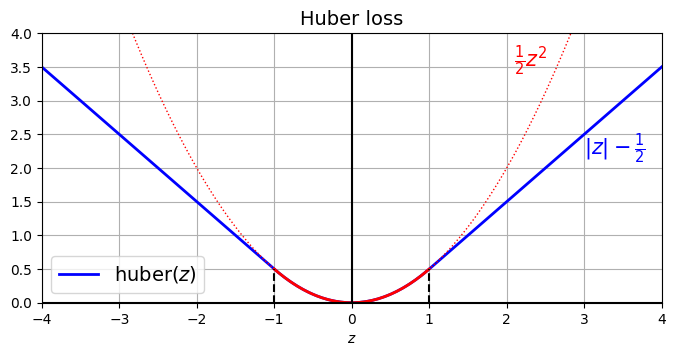

In [8]:
# extra code – shows what the Huber loss looks like

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [9]:
# extra code – loads, splits and scales the California housing dataset, then
#              creates a simple Keras model

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [10]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae", "accuracy"])

In [11]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 10s 8ms/step - loss: 0.6570 - mae: 1.0289 - accuracy: 0.0029 - val_loss: 0.3306 - val_mae: 0.6529 - val_accuracy: 0.0044
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2605 - mae: 0.5669 - accuracy: 0.0027 - val_loss: 0.2206 - val_mae: 0.5120 - val_accuracy: 0.0044


# Saving/Loading Models with Custom Objects

In [12]:
model.save("my_model_with_a_custom_loss")

In [13]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss",
                                   custom_objects={"huber_fn": huber_fn})

In [14]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 4s 5ms/step - loss: 0.2098 - mae: 0.4963 - accuracy: 0.0027 - val_loss: 0.1879 - val_mae: 0.4626 - val_accuracy: 0.0044
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1872 - mae: 0.4649 - accuracy: 0.0026 - val_loss: 0.1940 - val_mae: 0.4676 - val_accuracy: 0.0044


In [18]:
def create_huber(threshold=1.0):
 def huber_fn(y_true, y_pred):
  error = y_true - y_pred
  is_small_error = tf.abs(error) < threshold
  squared_loss = tf.square(error) / 2
  linear_loss = threshold * tf.abs(error) - threshold**2 / 2
  return tf.where(is_small_error, squared_loss, linear_loss)
 return huber_fn
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics = ["mae"])

In [19]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.2013 - mae: 0.4549 - val_loss: 0.2079 - val_mae: 0.4463
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1933 - mae: 0.4471 - val_loss: 0.1929 - val_mae: 0.4431


In [20]:
model.save("my_model_with_a_custom_loss_threshold_2")

In [21]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss_threshold_2",
                                   custom_objects={"huber_fn": create_huber(2.0)})

In [22]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 4s 6ms/step - loss: 0.1890 - mae: 0.4409 - val_loss: 0.1933 - val_mae: 0.4328
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1857 - mae: 0.4367 - val_loss: 0.1844 - val_mae: 0.4343
